In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

plt.rc('figure', figsize=(10, 7))

In [2]:
tf.__version__

'1.1.0-rc2'

## Loading data

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [5]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])
data.validation.cls = np.array([label.argmax() for label in data.validation.labels])

## Data dimensions

In [6]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = [img_size, img_size]
num_classes = 10

## Helper functions

In [7]:
# helper function to plot images
def plot_images(images, cls_true, cls_pred=None):
    img_cnt = len(images)

    # some sanity checks on inputs
    assert img_cnt == len(cls_true)
    if cls_pred is not None:
        assert img_cnt == len(cls_pred)

    # compute plot size. Do not plot more than 100 images
    plt_size = int(np.ceil(np.sqrt(img_cnt)))
    assert plt_size <= 10
    
    fig, axes = plt.subplots(plt_size, plt_size)
    
    # adjust spacing
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    empty_image = np.zeros(img_shape)

    for i, ax in enumerate(axes.flat):
        if i < img_cnt:
            ax.imshow(images[i].reshape(img_shape), cmap='binary')

            if cls_pred is not None:
                xlabel = 'True: {0}, Pred: {1}'.format(cls_true[i], cls_pred[i])
            else:
                xlabel = 'True: {0}'.format(cls_true[i])
        
            ax.set_xlabel(xlabel)
        else:
            ax.imshow(empty_image, cmap='binary')

        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

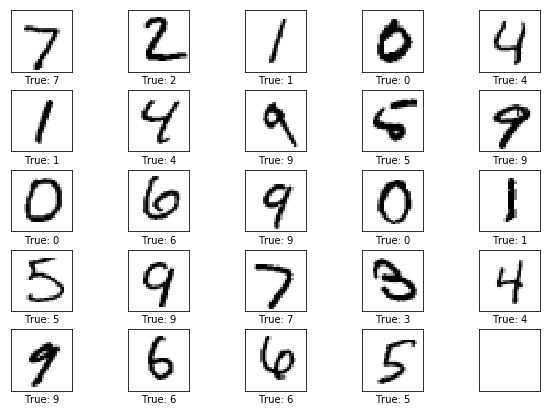

In [8]:
plot_images(data.test.images[0:24], data.test.cls[0:24])

# TensorFlow Graph

In [9]:
hl1_size = 256
hl2_size = 256

## Placeholder variables

In [10]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

## Weights & biases

In [11]:
weights = {
    'hl1': tf.Variable(tf.truncated_normal([img_size_flat, hl1_size], mean=0.0, stddev=0.01)),
    'hl2': tf.Variable(tf.truncated_normal([hl1_size, hl2_size], mean=0.0, stddev=0.01)),
    'out': tf.Variable(tf.truncated_normal([hl2_size, num_classes], mean=0.0, stddev=0.01))
}

biases = {
    'hl1': tf.Variable(tf.truncated_normal([hl1_size], mean=0.0, stddev=0.01)),
    'hl2': tf.Variable(tf.truncated_normal([hl2_size], mean=0.0, stddev=0.01)),
    'out': tf.Variable(tf.truncated_normal([num_classes], mean=0.0, stddev=0.01))
}

## Model

In [12]:
hl1 = tf.matmul(x, weights['hl1']) + biases['hl1']
hl1 = tf.nn.relu(hl1)

keep_prob = tf.placeholder(tf.float32)
hl1 = tf.nn.dropout(hl1, keep_prob)

hl2 = tf.matmul(hl1, weights['hl2']) + biases['hl2']
#hl2 = tf.nn.relu(hl2)

logits = tf.matmul(hl2, weights['out']) + biases['out']

y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)

## Cost function

In [13]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)
cost = tf.reduce_mean(cross_entropy)

## Opitmization method

In [14]:
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)
optimizer = tf.train.AdamOptimizer(learning_rate=6e-5).minimize(cost)

## Performance measures

In [15]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# TensorFlow Run

## Create a session

In [16]:
session = tf.Session()
session.run(tf.global_variables_initializer())

## Helper function to perform optimization iterations

In [17]:
batch_size = 128
def optimize(iterations):
    for i in range(iterations):
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        feed_dict = {x: x_batch, y_true: y_true_batch, keep_prob: 0.7}
        _, c = session.run([optimizer, cost], feed_dict=feed_dict)
        if i % 200 == 0:
            val_acc, c_acc = session.run([accuracy, cost],
                                  feed_dict={x: data.validation.images,
                                             y_true: data.validation.labels,
                                             y_true_cls: data.validation.cls,
                                             keep_prob: 1.0})
            print('{0}, {1:.4f}, {2:.4f}, {3:.2%}'.format(i, c, c_acc, val_acc))

## Helper functions to show performance

In [18]:
feed_dict_test = {x: data.test.images, y_true: data.test.labels, y_true_cls: data.test.cls, keep_prob: 1.0}

def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print('Accuracy on the test set: {0:.1%}'.format(acc))

def plot_confusion_matrix():
    cls_true = data.test.cls
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    print(cm)

    # plot the matrix as an image
    plt.matshow(cm)
    
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()

def plot_example_errors(num_errors=16):
    correct, cls_pred = session.run([correct_prediction, y_pred_cls], feed_dict=feed_dict_test)
    
    incorrect = (correct == False)
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]
    
    plot_images(images=images[0:num_errors],
                cls_true=cls_true[0:num_errors],
                cls_pred=cls_pred[0:num_errors])

## Helper function to plot the model's weights

In [19]:
def plot_weights(layer, shape=None):
    w = session.run(weights[layer])
    w_min = np.min(w)
    w_max = np.max(w)
    
    if shape is None:
        shape_side = int(np.ceil(np.sqrt(w.shape[0])))
        shape = [shape_side, shape_side]

    num_neurons = w.shape[1]
    num_subplots = int(np.ceil(np.sqrt(num_neurons)))
    
    fig, axes = plt.subplots(num_subplots, num_subplots, figsize=(14, 11))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        if i < num_neurons:
            image = w[:, i].reshape(shape)
            ax.set_xlabel(i)
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')
        
        ax.set_xticks([])
        ax.set_yticks([])

## Performance before any optimization

In [20]:
print_accuracy()

Accuracy on the test set: 9.8%


## Performance after one iteration

In [21]:
optimize(iterations=1)

0, 2.3016, 2.3022, 10.70%


In [22]:
print_accuracy()

Accuracy on the test set: 9.8%


## Further training

In [23]:
optimize(iterations=19999)

0, 2.3015, 2.3019, 10.70%
200, 1.2067, 1.2269, 64.58%
400, 0.7885, 0.7111, 78.84%
600, 0.6424, 0.5611, 84.28%
800, 0.3836, 0.4762, 86.72%
1000, 0.3914, 0.4239, 88.30%
1200, 0.3917, 0.3903, 89.34%
1400, 0.3355, 0.3663, 90.24%
1600, 0.4810, 0.3467, 90.52%
1800, 0.3097, 0.3305, 90.94%
2000, 0.3258, 0.3143, 91.10%
2200, 0.3140, 0.3041, 91.42%
2400, 0.3480, 0.2930, 91.82%
2600, 0.2950, 0.2830, 92.06%
2800, 0.2428, 0.2728, 92.32%
3000, 0.2869, 0.2650, 92.60%
3200, 0.4572, 0.2553, 92.64%
3400, 0.3970, 0.2465, 93.10%
3600, 0.2584, 0.2376, 93.42%
3800, 0.3143, 0.2306, 93.44%
4000, 0.1871, 0.2239, 93.68%
4200, 0.1908, 0.2152, 94.00%
4400, 0.1942, 0.2096, 94.20%
4600, 0.1842, 0.2030, 94.30%
4800, 0.2044, 0.1947, 94.60%
5000, 0.2898, 0.1890, 94.84%
5200, 0.1391, 0.1842, 94.92%
5400, 0.2106, 0.1787, 95.04%
5600, 0.1323, 0.1734, 95.30%
5800, 0.2080, 0.1677, 95.36%
6000, 0.1191, 0.1619, 95.60%
6200, 0.1734, 0.1589, 95.64%
6400, 0.2110, 0.1545, 95.78%
6600, 0.1746, 0.1508, 95.88%
6800, 0.2110, 0.1470,

In [24]:
print_accuracy()

Accuracy on the test set: 97.8%


[[ 970    0    0    2    1    1    3    1    2    0]
 [   0 1126    2    1    0    1    2    0    3    0]
 [   5    3 1001    6    4    0    2    6    5    0]
 [   0    0    5  990    1    5    0    5    4    0]
 [   0    0    2    0  961    0    6    4    2    7]
 [   2    0    0    9    2  869    3    0    5    2]
 [   4    3    0    0    6    5  939    0    1    0]
 [   1    6    9    4    0    0    0 1005    0    3]
 [   3    1    2    5    3    4    4    3  946    3]
 [   3    3    0    5   12    3    2    6    2  973]]


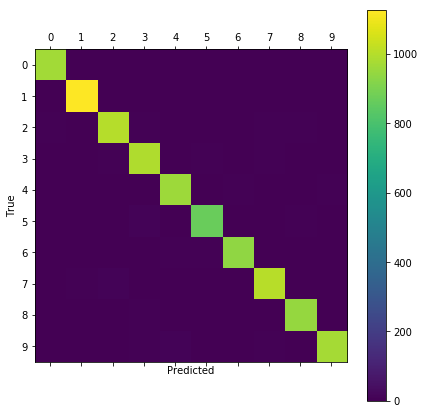

In [25]:
plot_confusion_matrix()

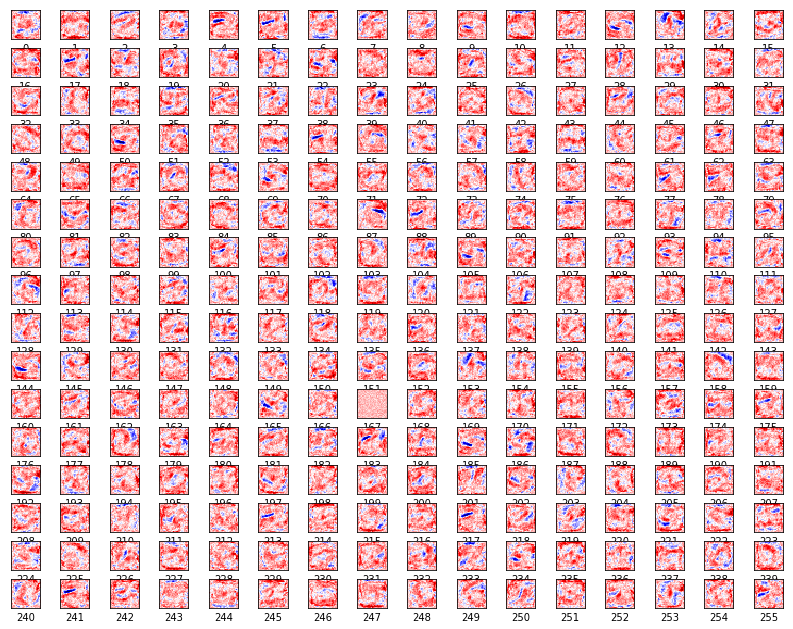

In [26]:
plot_weights('hl1')

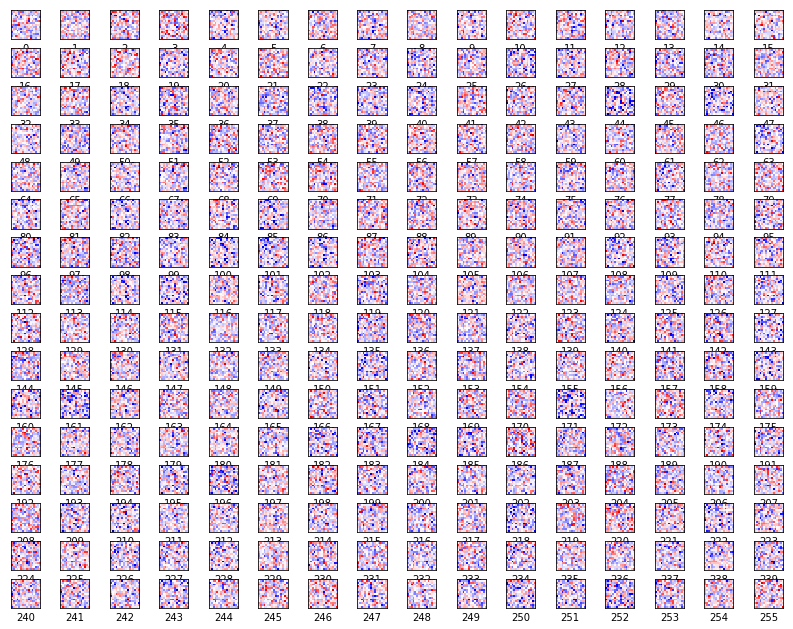

In [27]:
plot_weights('hl2')

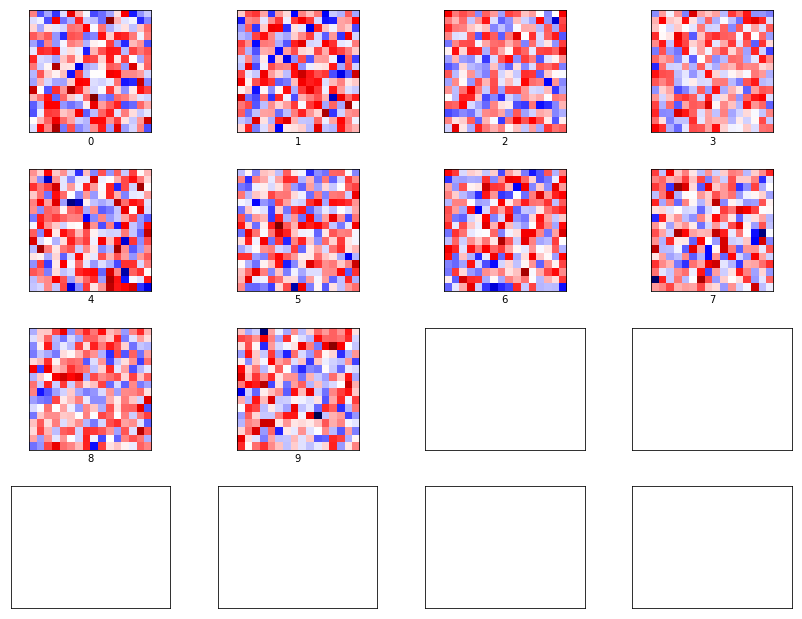

In [28]:
plot_weights('out')

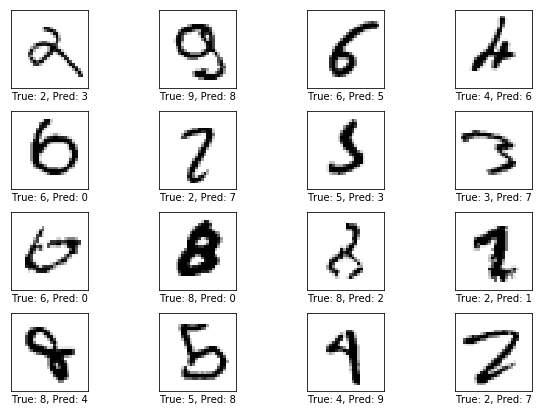

In [29]:
plot_example_errors()

In [31]:
# close TensorFlow Session
session.close()